In [ ]:
#pip install nona

Алгоритм на основе методов машинного обучения с прогнозированием по каждому столбцу с пропусками. [ссылка](https://habr.com/ru/post/709748/)

In [ ]:
#pip install catboost

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**  

DateCrawled — дата скачивания анкеты из базы - *судя по всему это дата когда данные попали к нам в руки, для исследования ценности не имеет*

VehicleType — тип автомобильного кузова  

RegistrationYear — год регистрации автомобиля - *может указать на раритетные и коллекционные авто, для прочего будет столбец возраста. Нужны ли данные о раритетных и коллекционных для обучения моделей? Сомнительно, могут только запутать*.  

Gearbox — тип коробки передач  

Power — мощность (л. с.)  

Model — модель автомобиля  

Kilometer — пробег (км)  

RegistrationMonth — месяц регистрации автомобиля - *не наблюдаю значимость этой информации*  

FuelType — тип топлива  

Brand — марка автомобиля  

Repaired — была машина в ремонте или нет  

DateCreated — дата создания анкеты - *если не учитывать год регистрации, что скажет нам о возрасте авто, то дата создания анкеты имеет влияние на цену только годичными колебаниями цен, считаю лучше создать отдельный столбец с возрастом авто и удалить этот.* 

NumberOfPictures — количество фотографий автомобиля - *это может повлиять на скорость продажи, но не на ценность*  

PostalCode — почтовый индекс владельца анкеты (пользователя) - *не наблюдаю значимость этой информации*  

LastSeen — дата последней активности пользователя - *не наблюдаю значимость этой информации*  

**Целевой признак**  

Price — цена (евро)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV,
    GridSearchCV, cross_val_score) 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import (
    LinearRegression, Ridge)
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler)
from nona.nona import nona

In [ ]:
RANDOM_STATE = 12345
TEST_SIZE = 0.40
TEST_SIZE_2 = 0.5
N_JOBS = -1
CV = 5

In [ ]:
plt.style.use('dark_background')

### Функции

In [ ]:
def encode(features_train, features_val, features_test):
    ohe_features = features_train.select_dtypes(
        include='object').columns.to_list()    
    ohe_features.remove('model')
    num_features = features_train.select_dtypes(
        exclude='object').columns.to_list()
    num_features.remove('repaired')    
    
    encoder_ohe = OneHotEncoder(drop='first', sparse=False)
    encoder_ohe.fit(features_train[ohe_features])
    try:
        features_train[
            encoder_ohe.get_feature_names()
        ] = encoder_ohe.transform(features_train[ohe_features])
    except:
        features_train[
            encoder_ohe.get_feature_names_out()
        ] = encoder_ohe.transform(features_train[ohe_features])
    features_train = features_train.drop(ohe_features, axis=1)
    
    scaler = StandardScaler()
    features_train[num_features] = scaler.fit_transform(
        features_train[num_features])    
    
    encoder_oe = OrdinalEncoder(
        handle_unknown='use_encoded_value', unknown_value=-1)
    encoder_oe.fit(features_train[['model']])
    features_train['model'
    ] = encoder_oe.transform(features_train[['model']])
    try:    
        features_val[
            encoder_ohe.get_feature_names()
        ] = encoder_ohe.transform(features_val[ohe_features])
    except:
        features_val[
            encoder_ohe.get_feature_names_out()
        ] = encoder_ohe.transform(features_val[ohe_features])
    features_val = features_val.drop(ohe_features, axis=1)    
    features_val[num_features] = scaler.transform(
        features_val[num_features])
    features_val['model'
    ] = encoder_oe.transform(features_val[['model']])
    try:    
        features_test[
            encoder_ohe.get_feature_names()
        ] = encoder_ohe.transform(features_test[ohe_features])
    except:
        features_test[
            encoder_ohe.get_feature_names_out()
        ] = encoder_ohe.transform(features_test[ohe_features])
    features_test = features_test.drop(ohe_features, axis=1)    
    features_test[num_features] = scaler.transform(
        features_test[num_features])
    features_test['model'
    ] = encoder_oe.transform(features_test[['model']])

    return features_train, features_val, features_test

## Подготовка данных

In [ ]:
try:
    df = pd.read_csv(r'C:\Users\keyten\Desktop\Info\Learning DS\projects\autos\autos.csv')
except:
    df = pd.read_csv(r'https://code.s3.yandex.net/datasets/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Присутствует много пропусков, бесполезные для задачи столбцы. Следует привести названия столбцов к подобающему виду и изменить тип столбца Repaired

### Создадим столбец с возрастом авто

In [ ]:
df['DateCreated'] = df['DateCreated'].map(lambda x: x[0:4]).astype(int)

In [ ]:
df['age'] = df['DateCreated']-df['RegistrationYear']

In [ ]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,age
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,0,70435,2016-04-07 03:16:57,23
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016-04-07 01:46:50,5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016-04-05 12:47:46,12


Для борьбы с выбросами надо знать последний год регистрации

In [ ]:
df['DateCreated'].max()

2016

### Удалим лишние столбцы

In [ ]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'age'],
      dtype='object')

In [ ]:
df = df.drop(columns=[
    'DateCrawled', 
    'RegistrationMonth', 
    'DateCreated', 
    'NumberOfPictures', 
    'LastSeen',
    'PostalCode'], axis=1)

In [ ]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'age'],
      dtype='object')

### Переименуем столбцы

In [ ]:
df = df.rename(columns={
    'Price':'price', 
    'VehicleType':'vehicle_type', 
    'RegistrationYear': 'registration_year', 
    'Gearbox':'gearbox', 
    'Power':'power', 
    'Model':'model',
    'Kilometer': 'kilometer', 
    'FuelType': 'fuel_type', 
    'Brand': 'brand', 
    'Repaired':'repaired',     
    'age':'age'    
})

### Установим удобный порядок столбцов

In [ ]:
df = df[['registration_year', 
         'age', 
         'brand', 
         'model', 
         'vehicle_type', 
         'fuel_type', 
         'gearbox', 
         'power',
         'kilometer', 
         'repaired', 
         'price']]

In [ ]:
df.head()

,registration_year,age,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,repaired,price
0,1993,23,volkswagen,golf,NaN,petrol,manual,0,150000,NaN,480
1,2011,5,audi,NaN,coupe,gasoline,manual,190,125000,yes,18300
2,2004,12,jeep,grand,suv,gasoline,auto,163,125000,NaN,9800
3,2001,15,volkswagen,golf,small,petrol,manual,75,150000,no,1500
4,2008,8,skoda,fabia,small,gasoline,manual,69,90000,no,3600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   registration_year  354369 non-null  int64 
 1   age                354369 non-null  int64 
 2   brand              354369 non-null  object
 3   model              334664 non-null  object
 4   vehicle_type       316879 non-null  object
 5   fuel_type          321474 non-null  object
 6   gearbox            334536 non-null  object
 7   power              354369 non-null  int64 
 8   kilometer          354369 non-null  int64 
 9   repaired           283215 non-null  object
 10  price              354369 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


### Изменим формат столбца repaired

In [ ]:
df['repaired'] = df['repaired'].replace({'yes':1, 'no':0})
df['repaired'] = df['repaired'].astype(float)
display(df.head())
df.info()

,registration_year,age,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,repaired,price
0,1993,23,volkswagen,golf,NaN,petrol,manual,0,150000,NaN,480
1,2011,5,audi,NaN,coupe,gasoline,manual,190,125000,1.0,18300
2,2004,12,jeep,grand,suv,gasoline,auto,163,125000,NaN,9800
3,2001,15,volkswagen,golf,small,petrol,manual,75,150000,0.0,1500
4,2008,8,skoda,fabia,small,gasoline,manual,69,90000,0.0,3600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   registration_year  354369 non-null  int64  
 1   age                354369 non-null  int64  
 2   brand              354369 non-null  object 
 3   model              334664 non-null  object 
 4   vehicle_type       316879 non-null  object 
 5   fuel_type          321474 non-null  object 
 6   gearbox            334536 non-null  object 
 7   power              354369 non-null  int64  
 8   kilometer          354369 non-null  int64  
 9   repaired           283215 non-null  float64
 10  price              354369 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 29.7+ MB


### Борьба с выбросами

In [ ]:
colls = ['registration_year', 'age', 'power', 'kilometer', 'price']

In [ ]:
for col in colls:
    print(col, df[col].nunique())

registration_year 151
age 151
power 712
kilometer 13
price 3731


In [ ]:
df = df[df['registration_year'] >= 1950]
df = df[df['registration_year'] <= 2016]

In [ ]:
df = df[df['power'] >= 50]
df = df[df['power'] <= 500]

In [ ]:
df = df[df['price'] >= 50]

In [ ]:
df[df['price'] == 20000]

,registration_year,age,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,repaired,price
1515,2010,6,audi,a6,sedan,gasoline,auto,239,150000,0.0,20000
1586,2014,2,seat,leon,sedan,gasoline,auto,184,40000,0.0,20000
2128,2014,2,kia,ceed,sedan,petrol,manual,135,30000,0.0,20000
3728,2011,5,mercedes_benz,c_klasse,sedan,gasoline,auto,265,50000,0.0,20000
6286,2009,7,mercedes_benz,e_klasse,sedan,gasoline,auto,272,150000,0.0,20000
...,...,...,...,...,...,...,...,...,...,...,...
342186,2012,4,bmw,5er,sedan,gasoline,manual,258,125000,1.0,20000
342303,2013,3,opel,insignia,sedan,gasoline,manual,194,60000,0.0,20000
348208,2011,5,mitsubishi,lancer,sedan,petrol,auto,241,40000,0.0,20000
349230,2008,8,mercedes_benz,viano,bus,gasoline,auto,204,125000,0.0,20000


Были обнаружены выбросы и принято решение удалить их вручную основываясь на соображениях разумности.

### Борьба с пропусками

In [ ]:
df.isna().sum()

registration_year        0
age                      0
brand                    0
model                10545
vehicle_type         10512
fuel_type            14795
gearbox               4924
power                    0
kilometer                0
repaired             41266
price                    0
dtype: int64

In [ ]:
colls = ['model', 'vehicle_type', 'fuel_type', 'gearbox', 'repaired']

In [ ]:
for col in colls:    
    print(f'Уникальные значения столбца {col} - {df[col].nunique()}:')
    print(sorted(df[col].astype(str).unique()), '\n')

Уникальные значения столбца model - 249:
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 

In [ ]:
colls=['brand', 'model', 'vehicle_type', 'fuel_type', 'gearbox']

In [ ]:
encoder_oe = OrdinalEncoder()
df[colls] = encoder_oe.fit_transform(df[colls])


In [ ]:
nona(df)

100%|██████████| 11/11 [00:32<00:00,  2.99s/it]


In [ ]:
df[colls] = encoder_oe.inverse_transform(df[colls])

In [ ]:
df.isna().sum()

registration_year    0
age                  0
brand                0
model                0
vehicle_type         0
fuel_type            0
gearbox              0
power                0
kilometer            0
repaired             0
price                0
dtype: int64

In [ ]:
df

,registration_year,age,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,repaired,price
1,2011,5,audi,captiva,coupe,gasoline,manual,190,125000,1.0,18300
2,2004,12,jeep,grand,suv,gasoline,auto,163,125000,0.0,9800
3,2001,15,volkswagen,golf,small,petrol,manual,75,150000,0.0,1500
4,2008,8,skoda,fabia,small,gasoline,manual,69,90000,0.0,3600
5,1995,21,bmw,3er,sedan,petrol,manual,102,150000,1.0,650
...,...,...,...,...,...,...,...,...,...,...,...
354361,2016,0,alfa_romeo,159,sedan,petrol,auto,150,150000,0.0,5250
354362,2004,12,seat,leon,sedan,petrol,manual,225,150000,1.0,3200
354366,2000,16,smart,fortwo,convertible,petrol,auto,101,125000,0.0,1199
354367,1996,20,volkswagen,transporter,bus,gasoline,manual,102,150000,0.0,9200


In [ ]:
df['repaired'] = df['repaired'].astype(int)

Пропуски были восстановлены используя алгоритм nona. При этом картинка графиков плотности не изменилась.

### Осмотр результатов проведенной работы

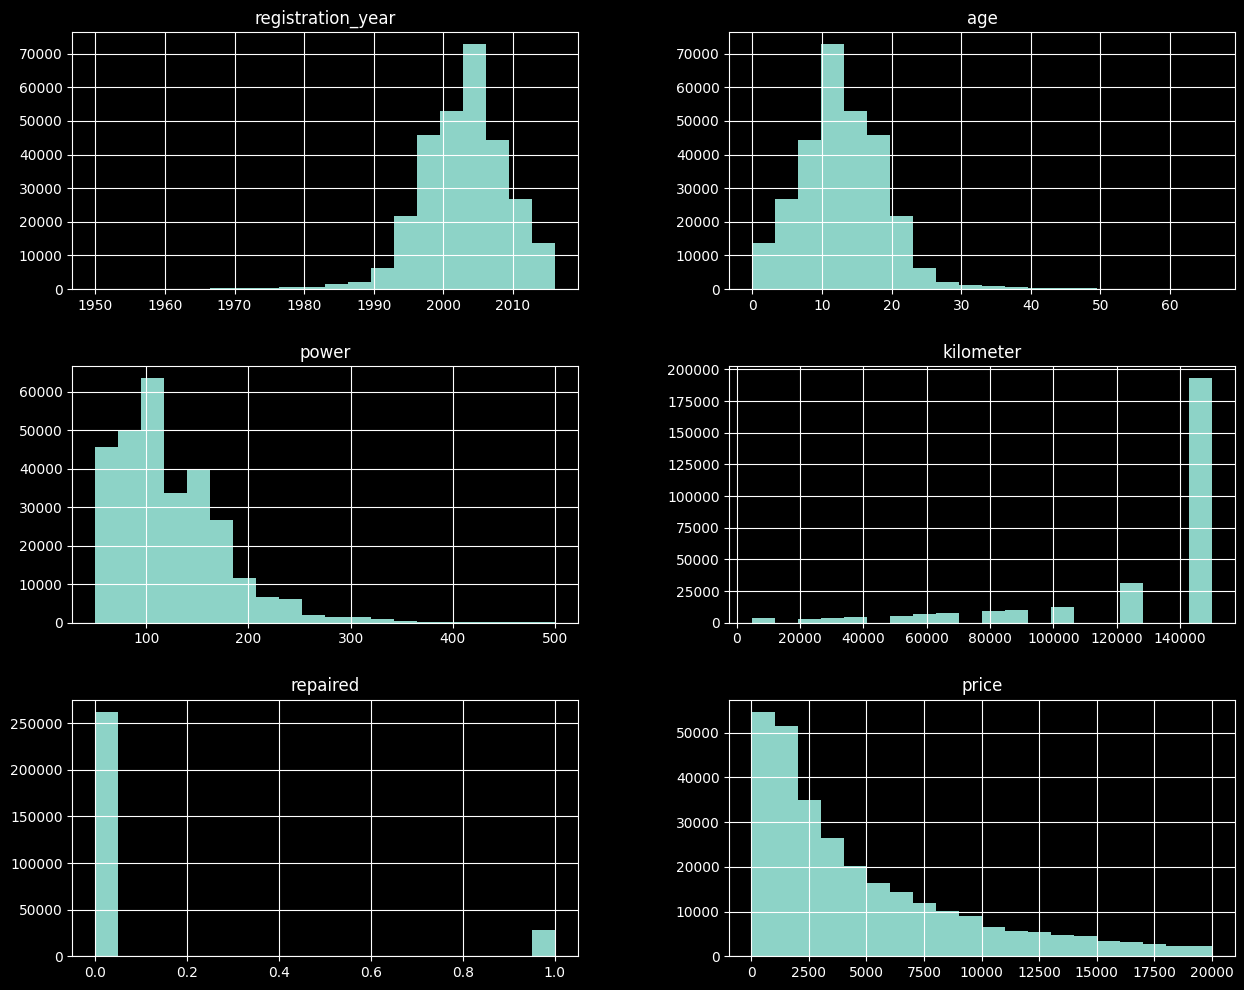

In [ ]:
df.hist(figsize=(15,12), bins=20);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290258 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   registration_year  290258 non-null  int64 
 1   age                290258 non-null  int64 
 2   brand              290258 non-null  object
 3   model              290258 non-null  object
 4   vehicle_type       290258 non-null  object
 5   fuel_type          290258 non-null  object
 6   gearbox            290258 non-null  object
 7   power              290258 non-null  int64 
 8   kilometer          290258 non-null  int64 
 9   repaired           290258 non-null  int32 
 10  price              290258 non-null  int64 
dtypes: int32(1), int64(5), object(5)
memory usage: 33.5+ MB


In [ ]:
for col in df.columns:
    print(f'Столбец {col}', '\n', df[col].describe(), '\n', sep='')

Столбец registration_year
count    290258.000000
mean       2002.980879
std           6.293555
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Столбец age
count    290258.000000
mean         13.019042
std           6.293571
min           0.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          66.000000
Name: age, dtype: float64

Столбец brand
count         290258
unique            40
top       volkswagen
freq           62663
Name: brand, dtype: object

Столбец model
count     290258
unique       249
top         golf
freq       24913
Name: model, dtype: object

Столбец vehicle_type
count     290258
unique         8
top        sedan
freq       88927
Name: vehicle_type, dtype: object

Столбец fuel_type
count     290258
unique         7
top       petrol
freq      196948
Name: fuel_type, dtype: object

Столбец gearbox
count     290258
unique         

Данные были изучены и приведены в подходящий для обучения моделей вид. Лишние столбцы удалены, выбросы удалены, пропуски восстановлены.

### Кодирование признаков

In [ ]:
features_train, features_pack,\
target_train, target_pack = train_test_split(
    df.drop(['price'], axis=1), df['price'],
    test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
features_val, features_test,\
target_val, target_test = train_test_split(
    features_pack, target_pack,
    test_size=TEST_SIZE_2, random_state=RANDOM_STATE)

In [ ]:
print('features_train', features_train.shape)
print('features_val', features_val.shape)
print('features_test', features_test.shape)

features_train (174154, 10)
features_val (58052, 10)
features_test (58052, 10)


In [ ]:
features_train, features_val, features_test = encode(features_train, features_val, features_test)

C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Было решено применить масштабирование для всех числовых столбцов кроме repaired, порядковое кодирование для столбца model(так как много уникальных значений) и прямое кодирование для остальных не числовых столбцов. 

## Обучение моделей

Будут обучаться модели:  
 - линейная регрессия - LinearRegression  
 - гребневая регрессия - Ridge  
 - ансамбль решающих деревьев - RandomForestRegressor  
 - градиентный бустинг - CatBoostRegressor  
   
Будет исследоваться их точность, время обучения, время работы.

In [ ]:
%%time
model_l = LinearRegression()
model_l.fit(features_train, target_train)
pred_l = model_l.predict(features_val)
print("RMSE =", mean_squared_error(target_val, pred_l) ** 0.5)

RMSE = 2747.2002706547
CPU times: total: 3.07 s
Wall time: 1.37 s


In [ ]:
%%time
model_l = LinearRegression()
rmse_cross_val_l = (cross_val_score(model_l, 
                                   features_train, 
                                   target_train,
                                  cv=CV,
                                  scoring='neg_mean_squared_error').
                    mean() * -1) ** 0.5
print("RMSE =", rmse_cross_val_l)

RMSE = 2739.3640422174944
CPU times: total: 11.7 s
Wall time: 5.56 s


In [ ]:
%%time
model_r = Ridge(random_state=RANDOM_STATE)
grid_params = [{'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}]
grid_model_r = GridSearchCV(model_r, 
    grid_params, 
    scoring='neg_mean_squared_error')
grid_model_r.fit(features_train, target_train)
print('best solver', grid_model_r.best_params_['solver'])
print("RMSE =", (grid_model_r.best_score_*-1)**0.5)

best solver auto
RMSE = 2739.3566127105155
CPU times: total: 6min 6s
Wall time: 5min 51s


C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_ridge.py", line 1130, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_ridge.py", line

In [ ]:
%%time
model_f = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
grid_params = [{'n_estimators':np.arange(50, 101, 10), 'max_depth':np.arange(10,30,5)}]
grid_model_f = GridSearchCV(model_f, 
    grid_params, 
    scoring='neg_mean_squared_error')
grid_model_f.fit(features_train, target_train)
print('best params', grid_model_f.best_params_)
print("RMSE =", (grid_model_f.best_score_*-1)**0.5)

best params {'max_depth': 20, 'n_estimators': 100}
RMSE = 1590.681810564274
CPU times: total: 6min 33s
Wall time: 57min 43s


In [ ]:
%%time
model_c = CatBoostRegressor()
model_c.fit(features_train, target_train)
pred_c = model_c.predict(features_val)
print("RMSE =", mean_squared_error(target_val, pred_c) ** 0.5)

Learning rate set to 0.092522
0:	learn: 4336.7481079	total: 82.1ms	remaining: 1m 21s
1:	learn: 4086.3177003	total: 103ms	remaining: 51.2s
2:	learn: 3861.9681893	total: 121ms	remaining: 40.3s
3:	learn: 3665.9043341	total: 140ms	remaining: 34.8s
4:	learn: 3487.3153978	total: 156ms	remaining: 31.1s
5:	learn: 3334.0330723	total: 177ms	remaining: 29.2s
6:	learn: 3192.7887867	total: 198ms	remaining: 28.1s
7:	learn: 3065.4498110	total: 217ms	remaining: 26.9s
8:	learn: 2953.7423214	total: 235ms	remaining: 25.9s
9:	learn: 2858.2163864	total: 254ms	remaining: 25.1s
10:	learn: 2770.5830855	total: 272ms	remaining: 24.5s
11:	learn: 2693.8886882	total: 292ms	remaining: 24s
12:	learn: 2625.5702241	total: 309ms	remaining: 23.5s
13:	learn: 2566.8232112	total: 326ms	remaining: 23s
14:	learn: 2513.2242901	total: 342ms	remaining: 22.5s
15:	learn: 2464.6709785	total: 360ms	remaining: 22.1s
16:	learn: 2420.5979150	total: 380ms	remaining: 22s
17:	learn: 2385.2513521	total: 397ms	remaining: 21.7s
18:	learn: 2

|Модель|Время поиска|RMSE|
|:-|:-|:-|
|LinearRegression|7.32 сек|2741 EUR|
|Ridge|6 мин 33 сек|2741 EUR|
|RandomForestRegressor|1 ч 31 мин 19 сек|1567 EUR|
|CatBoostRegressor| - |1569 EUR|

RandomForestRegressor и CatBoostRegressor показали лучший RMSE.

## Анализ моделей

In [ ]:
%%time
model_f = RandomForestRegressor(random_state=RANDOM_STATE,
                                n_jobs=N_JOBS, max_depth=25, n_estimators=100)
model_f.fit(features_train, target_train)

CPU times: total: 3min 18s
Wall time: 52.4 s


RandomForestRegressor(max_depth=25, n_jobs=-1, random_state=12345)

In [ ]:
%%time
pred_f = model_f.predict(features_val)
print("RMSE =", mean_squared_error(target_val, pred_f) ** 0.5)

RMSE = 1563.478786629162
CPU times: total: 3.21 s
Wall time: 880 ms


In [ ]:
%%time
pred_c = model_c.predict(features_val)
print("RMSE =", mean_squared_error(target_val, pred_c) ** 0.5)

RMSE = 1576.720096332746
CPU times: total: 78 ms
Wall time: 27 ms


|Модель|Время обучения|Время предсказания|RMSE|
|:-|:-|:-|:-|
|RandomForestRegressor|1 мин 15 сек|1.3 сек|1542 EUR|
|CatBoostRegressor|20.3 сек|58 мс|1569 EUR|

Считаю использование RandomForestRegressor лучшим решением. Хоть он и работает дольше чем CatBoostRegressor, но точность выше, а время предсказания 1 сек не достаточно много чтобы отказаться от этой модели.

## Тестирование лучшей модели

In [ ]:
pred_f = model_f.predict(features_test)
print("RMSE =", mean_squared_error(target_test, pred_f) ** 0.5)

RMSE = 1571.8832129920056


Предложенная модель показала удовлетворительные результы метрики RMSE на тестовой выборке. Таким образом предлагаю эту модель для дальнейшего определения стоимости автомобилей.